# Attention network

## Imports

In [187]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import emoji
import random
import time
import warnings
import itertools

warnings.filterwarnings('ignore')

import sys
sys.path.append("../") # make it possible to import functions from different files that are in folders a level up

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin' # used for displaying the model plot

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Dense, Dropout, Attention, AveragePooling1D, Input, Conv1D, GlobalAveragePooling1D, Embedding, Concatenate
from data.functions.string_tools import print_split_shapes
from keras.callbacks import History

from tensorflow.keras.utils import plot_model
from transformers import AutoTokenizer
from text.tools.bert_model import MAX_LEN

# SEEDS
random_state = 111

os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

epochs = 30
batch_size= 64
txt_size= 16

## Check if a GPU is available

In [2]:
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print("No GPU found")

GPU found


## Load the data in

In [3]:
folder_path = '../data/selected_data/all_data_selected.csv'

df = pd.read_csv(folder_path)

df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,full_text,retweet_count,user_description,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,hashtags_count,username,...,part_of_thread,tweet_sentiment,user_creation_tweet_diff,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade
0,Our daily update is published. States reported...,171,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,The COVID Tracking Project,...,0,0,16384932,0,1,0,0,0,0,1.0
1,President Trump Asked What He Would Do If He W...,0,"Spoof news, political satire, parody and more!...",803,97,1,57502,3,2,The Spoof,...,0,0,293776787,1,0,0,0,0,0,-1.0
2,States reported 630 deaths. We are still seein...,71,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,The COVID Tracking Project,...,1,0,9039963,0,1,0,0,0,0,1.0
3,Low #vitaminD was an independent predictor of ...,40,Medscape provides breaking medical news and ex...,215969,39457,2206,49892,16563,1,Medscape,...,0,1,375950159,0,0,0,1,0,1,1.0
4,A common question: why are the cumulative outc...,0,We try to provide the most comprehensive state...,468030,13,85,2594,1364,1,The COVID Tracking Project,...,1,2,2470004,0,1,0,0,0,0,1.0


## Prepare the data

### Drop duplicated and not set fields

In [4]:
df['user_description'] = df['user_description'].apply(lambda x: x if pd.notna(x) else '')
print(df.shape)
df = df.dropna(subset=['full_text']).drop_duplicates(subset=['full_text'])
df.shape

(7905, 44)


(7816, 44)

### Combine text fields

In [5]:
df['text'] = df['full_text']
df['user_info'] = df['username'] + ' ' + df['user_description']

df.drop(['username', 'user_description'], axis=1, inplace=True)

df.head()

,full_text,retweet_count,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,hashtags_count,has_user_url,text_length,...,user_creation_tweet_diff,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade,text,user_info
0,Our daily update is published. States reported...,171,468030,13,85,2594,1364,0,1,163,...,16384932,0,1,0,0,0,0,1.0,Our daily update is published. States reported...,The COVID Tracking Project We try to provide t...
1,President Trump Asked What He Would Do If He W...,0,803,97,1,57502,3,2,1,125,...,293776787,1,0,0,0,0,0,-1.0,President Trump Asked What He Would Do If He W...,"The Spoof Spoof news, political satire, parody..."
2,States reported 630 deaths. We are still seein...,71,468030,13,85,2594,1364,0,1,245,...,9039963,0,1,0,0,0,0,1.0,States reported 630 deaths. We are still seein...,The COVID Tracking Project We try to provide t...
3,Low #vitaminD was an independent predictor of ...,40,215969,39457,2206,49892,16563,1,1,112,...,375950159,0,0,0,1,0,1,1.0,Low #vitaminD was an independent predictor of ...,Medscape Medscape provides breaking medical ne...
4,A common question: why are the cumulative outc...,0,468030,13,85,2594,1364,1,1,277,...,2470004,0,1,0,0,0,0,1.0,A common question: why are the cumulative outc...,The COVID Tracking Project We try to provide t...


In [6]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [7]:
def clean_text(text):
    text = text.lower()

    # vervang alle urls
    text = re.sub('https?://\S+|www\.\S+', 'HTTPADDR', text)
    
    # verwijder punctuation
    text = text.translate(str.maketrans('','', string.punctuation))
    # vervang emojis door  'EMOJI'
    text = emoji.demojize(text)
    text = re.sub(r"\:(.*?)\:", ' EMOJI ',text)
    # vervang getallen door 'NUMMER'
    text = re.sub(r"\b[\d.]+\b", " NUMMER ", text)
    # vervang opeenvolgende spaties en tabs door een enkele spatie
    text = re.sub(r"\s+", " ", text)

    # Removing the stopwords from text
    new_text = []

    tokenized = word_tokenize(text)

    for word in tokenized:
        if word not in stop_words:
            word = word.strip() # haal spaties aan uiteinde weg
            word = lemmatizer.lemmatize(word) # rocks -> rock, better -> good, running -> run
            new_text.append(word)

    
    
    text = ' '.join(lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words)
    

    # verwijder onnodige spaties aan begin en eind
    text = text.strip()

    return text


In [8]:
print('before:')
print(df['text'][74])

print('\nafter:')
print(clean_text(df['text'][74]))

before:
@globaltimesnews It doesn’t effect randians coz they have CowUrine for cure🐄💦💁🏿‍♂️ after all they have bad smell to tackle COVID-19 with Cow-dung

after:
globaltimesnews ’ effect randians coz cowurine cure EMOJI EMOJI EMOJI bad smell tackle covid19 cowdung


In [9]:
df['text'] = df['text'].apply(clean_text)
df['full_text'] = df['full_text'].apply(clean_text)
df['user_info'] = df['user_info'].apply(clean_text)

In [10]:
x_text = df[['text', 'user_info']]

x_meta_data = df
# x_meta_data= df.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])

y = df['real_fake_grade']

print('x_text: ', x_text.shape, '\nx_meta_data', x_meta_data.shape, '\ny', y.shape)

x_text:  (7816, 2) 
x_meta_data (7816, 44) 
y (7816,)


### Split the data into metadata and text sets

In [11]:
x_train_meta_data, x_test_meta_data, x_train_text, x_test_text = train_test_split(x_meta_data, x_text, test_size=.2, random_state=random_state)

x_train_user_info = x_train_text['user_info']
x_test_user_info = x_test_text['user_info']

x_train_tweet = x_train_text['text']
x_test_tweet = x_test_text['text']

y_train = x_train_meta_data['real_fake_grade'].values
y_test = x_test_meta_data['real_fake_grade'].values

x_train_meta_data = x_train_meta_data.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])
x_test_meta_data = x_test_meta_data.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])

In [12]:
def print_shapes():
  print('Meta data shapes:')
  print_split_shapes(x_train_meta_data, y_train, x_test_meta_data, y_test)

  print('Tweet data shapes:')
  print_split_shapes(x_train_text, y_train, x_test_text, y_test)

  print('User info data shapes:')
  print_split_shapes(x_train_user_info, y_train, x_test_user_info, y_test)

print_shapes()

Meta data shapes:
Train shapes
	X:(6252, 40)
	y:(6252,)
Test shapes
	X:(1564, 40)
	y:(1564,)
Tweet data shapes:
Train shapes
	X:(6252, 2)
	y:(6252,)
Test shapes
	X:(1564, 2)
	y:(1564,)
User info data shapes:
Train shapes
	X:(6252,)
	y:(6252,)
Test shapes
	X:(1564,)
	y:(1564,)


### Transform the data into better (machine) readable sets

In [13]:
# scale the metadata
scaler = StandardScaler()

x_train_meta_data = scaler.fit_transform(x_train_meta_data)
x_test_meta_data = scaler.transform(x_test_meta_data)

# the y labels contains 3 possible values, -1, 0 and 1. Negative labels are not accepted by a neural net so these must be transformed
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print_shapes()

Meta data shapes:
Train shapes
	X:(6252, 40)
	y:(6252,)
Test shapes
	X:(1564, 40)
	y:(1564,)
Tweet data shapes:
Train shapes
	X:(6252, 2)
	y:(6252,)
Test shapes
	X:(1564, 2)
	y:(1564,)
User info data shapes:
Train shapes
	X:(6252,)
	y:(6252,)
Test shapes
	X:(1564,)
	y:(1564,)


### Tokenize the text

In [14]:
tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

def tokenize(X):
  return tokenizer(
    text=X.tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
  )

# Tokenize the input (takes some time)
x_train_tweet_tokenized = tokenize(x_train_tweet)
x_test_tweet_tokenized = tokenize(x_test_tweet)

x_train_user_text_tokenized = tokenize(x_train_user_info)
x_test_user_text_tokenized = tokenize(x_test_user_info)

bert_train_tweet_input = { 'input_ids': x_train_tweet_tokenized['input_ids'], 'attention_mask': x_train_tweet_tokenized['attention_mask'] }
bert_test_tweet_input = { 'input_ids': x_test_tweet_tokenized['input_ids'], 'attention_mask': x_test_tweet_tokenized['attention_mask'] }

bert_train_user_text_input = { 'input_ids': x_train_user_text_tokenized['input_ids'], 'attention_mask': x_train_user_text_tokenized['attention_mask'] }
bert_test_user_text_input = { 'input_ids': x_test_user_text_tokenized['input_ids'], 'attention_mask': x_test_user_text_tokenized['attention_mask'] }

## Model building

### Used functions

In [195]:
from typing import TypedDict

class AttentionDict(TypedDict):
  query: list
  key: list|None
  value:list

def train(network: Model, x_train_input: AttentionDict, x_test_input: AttentionDict, name: str) -> pd.DataFrame:
  # The order for attention input is query, key and then value
  ordered_train_input = [x_train_input['query']]

  ordered_test_input = [x_test_input['query']]

  if 'key' in x_train_input:
    ordered_train_input.append(x_train_input['key'])
    ordered_test_input.append(x_test_input['key'])
  
  ordered_train_input.append(x_train_input['value'])
  ordered_test_input.append(x_test_input['value'])

  start_time = time.time()
  history: History = network.fit(
    x=ordered_train_input,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.2,
    verbose=0
  )

  train_score = network.evaluate(ordered_train_input, y_train, verbose=0)

  test_score = network.evaluate(ordered_test_input, y_test, verbose=0)
  print(f'\nEvaluation:\nTest loss: {test_score[0]} / Test accuracy: {test_score[1]}')

  predictions = network.predict(ordered_test_input)

  elapsed_time = time.time() - start_time
  print(f'\tExecution time (seconds): {elapsed_time}')

  return pd.DataFrame({
    'Name': [name],
    'Test_Accuracy': [test_score[1]],
    'Test_Loss': [test_score[0]],
    "Train_Accuracy's": [history.history['accuracy']],
    'Train_Losses': [history.history['loss']],
    "Val_Accuracy's": [history.history['val_accuracy']],
    'Val_Losses': [history.history['val_loss']],
    'Train_Loss': [train_score[0]],
    'Train_Accuracy': [train_score[1]],
    'Y_test': [y_test],
    'Predictions': [predictions],
    'Execution_time': [elapsed_time]
  })

def plot_results(name:str, models: list[pd.DataFrame], show_overfitting:bool = True):
  def set_basics(ax, title, x_label, y_label):
    ax.set_title(title, size=txt_size)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
  
  def set_plot_basics(ax, title, loss=False):
    ax.grid()
    ax.legend()
    set_basics(ax, title, 'Epochs', 'Loss' if loss else 'Accuracy')
  
  def set_bar_basics(ax, title, x, y, x_label, y_label, round_num=3, abbr = ''):
    set_basics(ax, title, x_label, y_label)
    bar = concat.plot.bar(y=y, x=x, ax=ax)

    ax.legend(loc='lower right')

    for container in bar.containers:
      ax.bar_label(container, size=txt_size, fmt=f'%.{round_num}f{abbr}')

  rows = 3
  cols = 3
  figsize = (25, 22)

  if show_overfitting:
    cols = 2
    figsize = (25, 25)
  
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

  fig.suptitle(f'{name} model comparison', size=txt_size*1.5)

  concat = pd.concat(models)

  concat = concat.sort_values(by=['Test_Accuracy'], ascending=[False])

  axes = axes.flatten()

  if show_overfitting:
    [acc_ax, loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _] = axes
  else:
    [train_acc_ax, val_acc_ax, train_loss_ax, val_loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _, __] = axes

  for _, row in concat.iterrows():
    name = row['Name']
    if show_overfitting:
      acc_ax.plot(row["Train_Accuracy's"], label=name + '-Train', alpha=0.7)
      acc_ax.plot(row["Val_Accuracy's"], label=name + '-Validate', alpha=0.7)

      loss_ax.plot(row["Train_Losses"], label=name + '-Train', alpha=0.7)
      loss_ax.plot(row["Val_Losses"], label=name + '-Validate', alpha=0.7)
    else:
      train_acc_ax.plot(row["Train_Accuracy's"], label=name)
      val_acc_ax.plot(row["Val_Accuracy's"], label=name)

      val_loss_ax.plot(row["Val_Losses"], label=name)
      train_loss_ax.plot(row["Train_Losses"], label=name)
    
    # print the classification report
    y_test = row['Y_test']
    predictions = row['Predictions']

    flattend_pred = []
    # the predictions is an array of n rows with a depth of 3 so shape: (n, 3)
    # the classification report function only accepts 1D arrays so we need to 'flatten' the predictions
    for preds in predictions:
      highest = max(preds)
      index = list(preds).index(highest)

      # 0 = fake; 1 = neutral; 2 = real
      flattend_pred.append(index)
    print(f'{name} classification report:')
    print(classification_report(y_test, flattend_pred))

  set_bar_basics(
    ax = acc_bar_ax,
    title='Evaluation accuracy comparison\n(Higher is better)',
    x = 'Name',
    y = ['Test_Accuracy', 'Train_Accuracy'],
    x_label='Name',
    y_label='Accuracy'
  )

  set_bar_basics(
    ax = loss_bar_ax,
    title='Evaluation loss comparison\n(Lower is better)',
    x = 'Name',
    y = ['Test_Loss', 'Train_Loss'],
    x_label='Name',
    y_label='Loss'
  )
  
  set_bar_basics(
    ax = time_ax,
    title='Execution time\n(In seconds & lower is better)',
    x = 'Name',
    y = ['Execution_time'],
    x_label='Name',
    y_label='Execution time',
    round_num=2,
    abbr='s'
  )

  if show_overfitting:
    acc_ax.set_xlim([0,epochs-1])
    loss_ax.set_xlim([0,epochs-1])

    set_plot_basics(acc_ax, 'Accuracy')
    set_plot_basics(loss_ax, 'Loss', True)
    pass
  else:
    train_acc_ax.set_xlim([0,epochs-1])
    val_acc_ax.set_xlim([0,epochs-1])
    train_loss_ax.set_xlim([0,epochs-1])
    val_loss_ax.set_xlim([0,epochs-1])

    set_plot_basics(train_acc_ax, 'Training accuracy')
    set_plot_basics(val_acc_ax, 'Validating accuracy')

    set_plot_basics(train_loss_ax, 'Training loss comparison', True)
    set_plot_basics(val_loss_ax, 'Validating loss comparison', True)
  
  plt.show()
  pass

def attention_network(useKey:bool):
  # Variable-length int sequences.
  query_input = Input(shape=(None,), dtype='int32', name='query-input')
  value_input = Input(shape=(None,), dtype='int32', name='value-input')

  inputs = [query_input]

  if useKey:
    # add key input
    inputs.append(Input(shape=(None,), dtype='int32', name='key-input'))

  inputs.append(value_input)

  # Embedding lookup.
  token_embedding = Embedding(input_dim=10000, output_dim=64)

  # CNN layer.
  cnn_layer = Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  
  cnn_layer_2 = Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  pooling_1 = AveragePooling1D()

  cnn_encoded = []

  # all inputs go through the embedding and cnn layer
  for input in inputs:
    embeddings = token_embedding(input)
    seq_encoded = cnn_layer(embeddings)

    seq_encoded = pooling_1(seq_encoded)
    # seq_encoded = cnn_layer_2(seq_encoded)

    cnn_encoded.append(seq_encoded)

  # the first two inputs query and key OR query and value (depending if the key is used)
  # go through the Attention layer
  query_value_attention_seq = Attention(name='query-key-attention')(
      [cnn_encoded[0], cnn_encoded[1]])

  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_value_attention = GlobalAveragePooling1D(name='attention_pooling')(
      query_value_attention_seq)

  query_encoding = GlobalAveragePooling1D(name='value_pooling')(
      cnn_encoded[2] if useKey else cnn_encoded[0])

  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = Concatenate(name='attention-value-concatenatation')(
      [query_value_attention, query_encoding])

  x = Dense(units=128, activation='relu', name='dense_1')(input_layer)
  x = Dropout(.3, name='dropout_1')(x)

  x = Dense(units=64, activation='relu', name='dense_2')(x)
  x = Dropout(.8, name='dropout_2')(x)

  output_layer = Dense(units=3, activation='softmax', name='output_layer')(x)

  model = Model(inputs=inputs, outputs=output_layer)

  # model.summary()
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

def get_inputs(useKey:bool):
  train_input = AttentionDict(
    query=x_train_meta_data,
    value=x_train_tweet_tokenized['input_ids']
  )

  test_input = AttentionDict(
    query=x_test_meta_data,
    value=x_test_tweet_tokenized['input_ids']
  )

  if useKey:
    train_input['key'] = x_train_user_text_tokenized['input_ids']
    test_input['key'] = x_test_user_text_tokenized['input_ids']

  return train_input, test_input

### Programatically use all possible combinations for the attention layer inputs

In [188]:
combinations = [
  ('metadata', x_train_meta_data, x_test_meta_data),
  ('userinfo', x_train_user_text_tokenized['input_ids'], x_test_user_text_tokenized['input_ids']),
  ('tweet', x_train_tweet_tokenized['input_ids'], x_test_tweet_tokenized['input_ids'])
]

all_scores = []

for L in range(1, len(combinations)+1):
  # place the combinations in different subsets
  for subset in itertools.combinations(combinations, L):
    set_key = len(subset) == 3
    train_inputs, test_inputs = get_inputs(set_key)

    name = subset[0][0]

    train_inputs['query'] = subset[0][1]
    test_inputs['query'] = subset[0][2]

    if set_key:
      # three values in the subset
      train_inputs['key'] = subset[1][1]
      test_inputs['key'] = subset[1][2]
      train_inputs['value'] = subset[2][1]
      test_inputs['value'] = subset[2][2]

      name += f'-{subset[1][0]}-{subset[2][0]}'
    elif len(subset) == 1:
      # one value in the subset
      train_inputs['value'] = subset[0][1]
      test_inputs['value'] = subset[0][2]
    else:
      # 2 values in the subset
      train_inputs['value'] = subset[1][1]
      test_inputs['value'] = subset[1][2]

      name += f'-{subset[1][0]}'
    
    network = attention_network(set_key)

    print(f'\nRunning attention network with: {name}')

    scores = train(
      network=network,
      name=name,
      x_train_input=train_inputs,
      x_test_input=test_inputs
    )

    # append the current scores to the total
    all_scores.append(scores)

Running attention network with: metadata

Evaluation:
Test loss: 0.8147602677345276 / Test accuracy: 0.6131713390350342
	Execution time (seconds): 25.383827686309814
Running attention network with: userinfo

Evaluation:
Test loss: 2.7219974994659424 / Test accuracy: 0.6726342439651489
	Execution time (seconds): 24.09848976135254
Running attention network with: tweet

Evaluation:
Test loss: 7.0303497314453125 / Test accuracy: 0.6528133153915405
	Execution time (seconds): 24.358648777008057
Running attention network with: metadata-userinfo

Evaluation:
Test loss: 4.8913469314575195 / Test accuracy: 0.6764705777168274
	Execution time (seconds): 24.21017861366272
Running attention network with: metadata-tweet

Evaluation:
Test loss: 3.952319622039795 / Test accuracy: 0.6617646813392639
	Execution time (seconds): 24.121636152267456
Running attention network with: userinfo-tweet

Evaluation:
Test loss: 2.9341928958892822 / Test accuracy: 0.7461636662483215
	Execution time (seconds): 24.08341

### Display all the results in one plot

userinfo-tweet classification report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       434
           1       0.41      0.43      0.42       192
           2       0.88      0.80      0.84       938

    accuracy                           0.75      1564
   macro avg       0.65      0.67      0.66      1564
weighted avg       0.76      0.75      0.75      1564

metadata-userinfo-tweet classification report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       434
           1       0.42      0.35      0.38       192
           2       0.84      0.82      0.83       938

    accuracy                           0.74      1564
   macro avg       0.64      0.64      0.64      1564
weighted avg       0.74      0.74      0.74      1564

metadata-userinfo classification report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       434
   

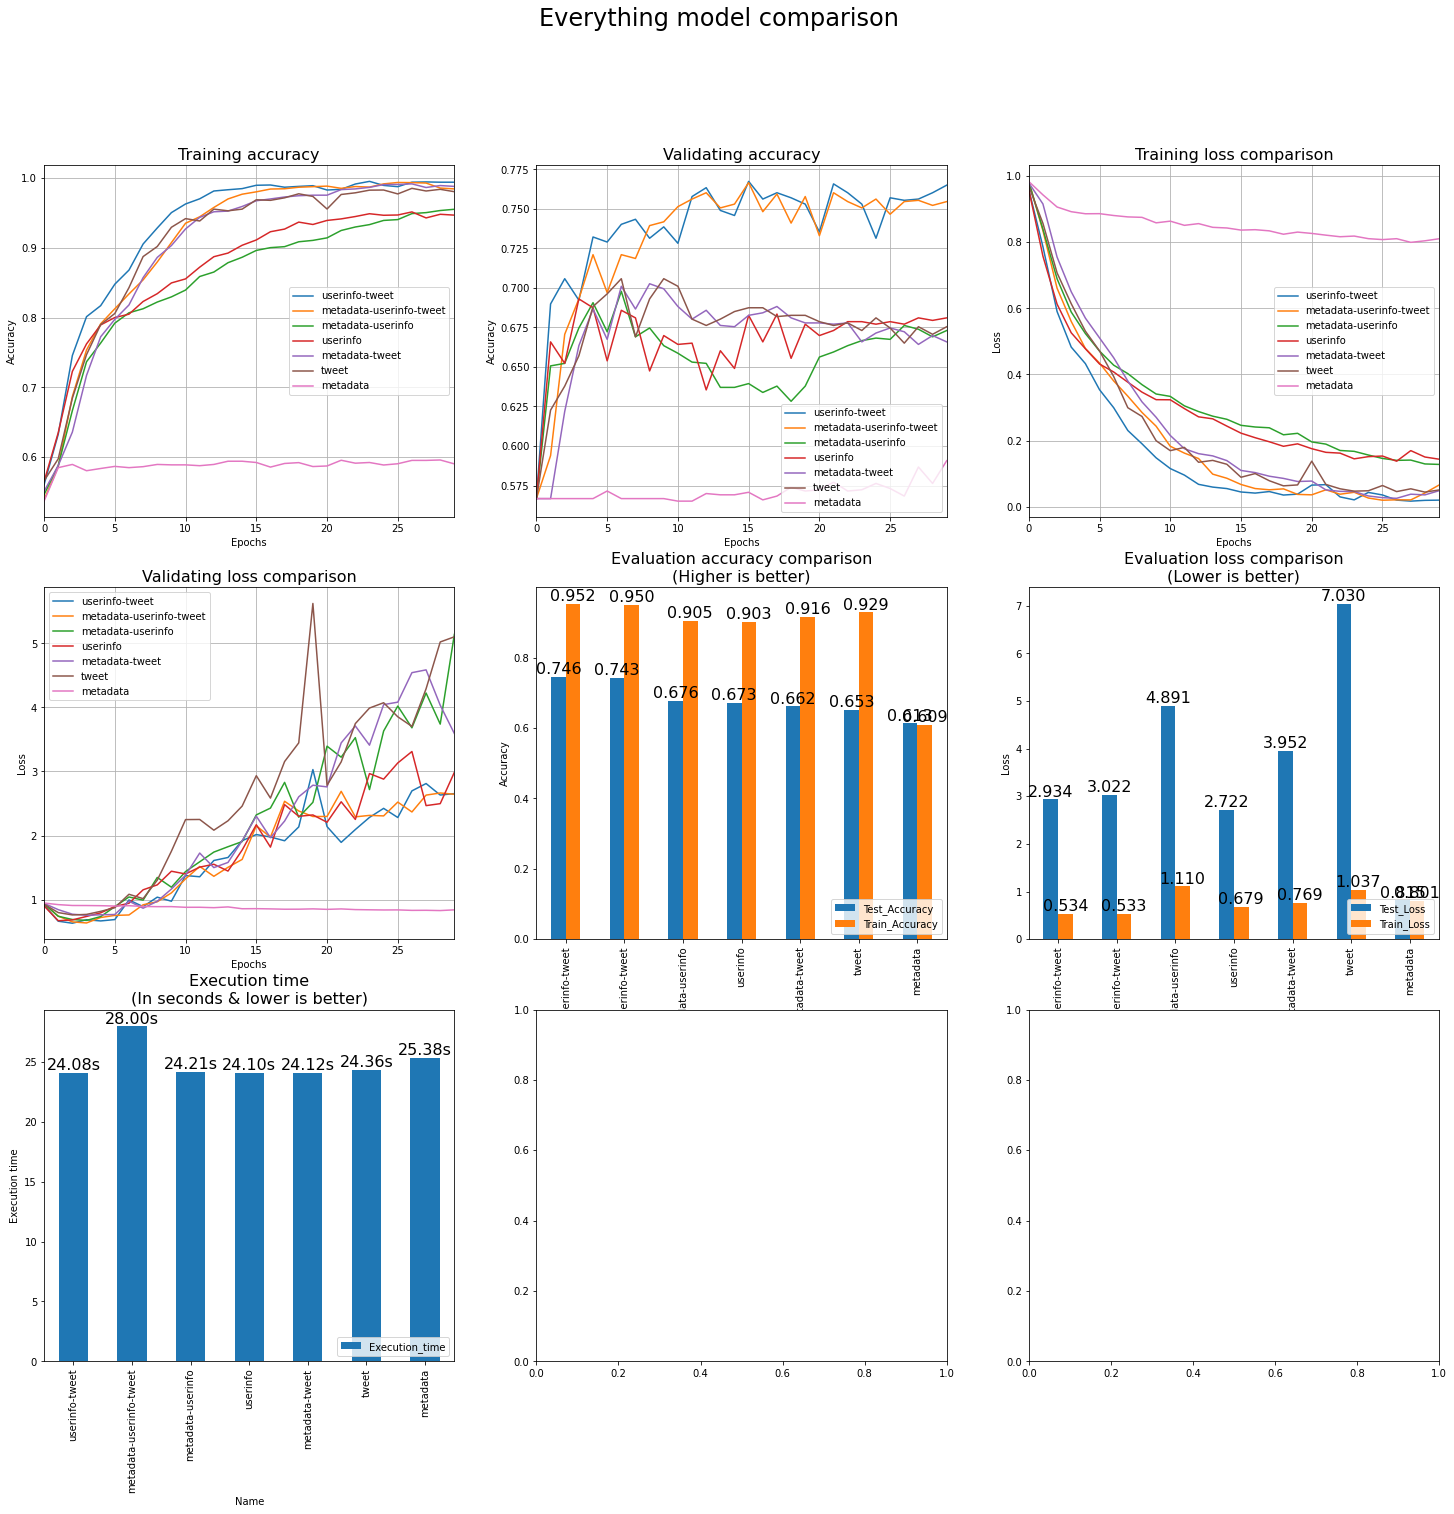

In [191]:
plot_results('Everything', all_scores, False)

### See the network as a plot

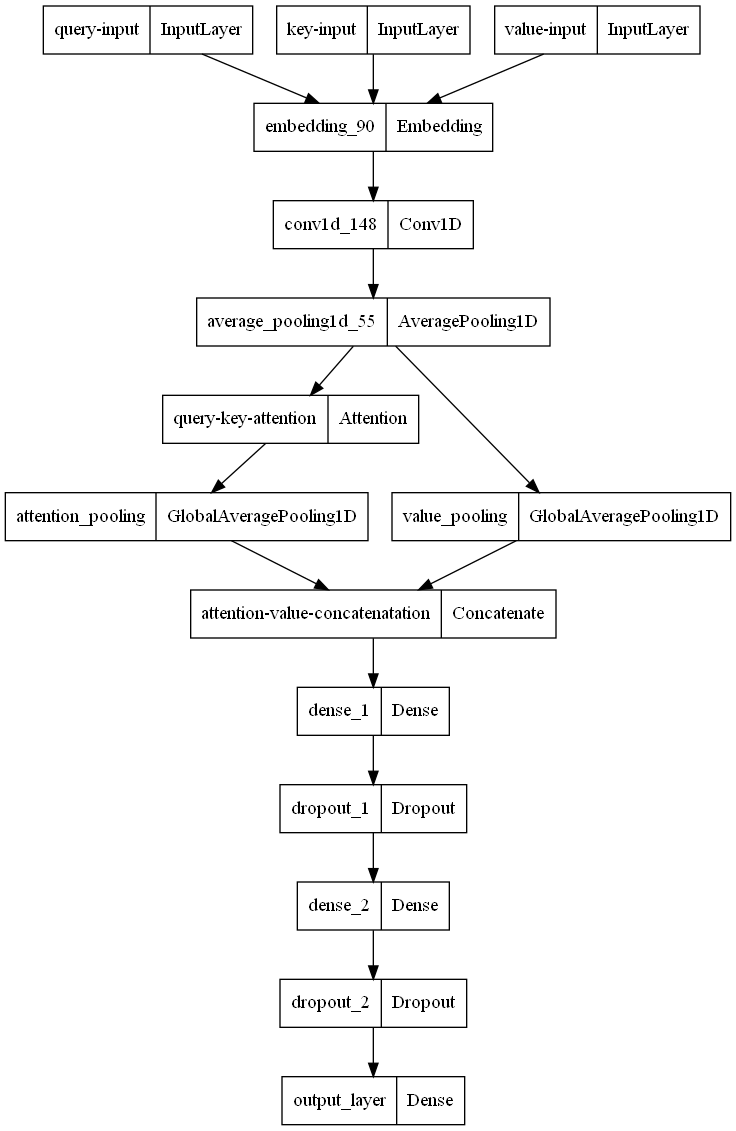

In [196]:
plot_model(attention_network(True))